# Sentiment Analysis in Python

Sentiment analysis in python using two different techniques and then comparing their sore:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model

Data link - [Click here](https://drive.google.com/file/d/1jQ90hOkq0U_uAKelW2B_vUuUImgUc0yP/view?usp=sharing)

# Import all the required libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

# Read in data file

In [18]:
df = pd.read_csv('/content/drive/MyDrive/NLP-Project/Reviews.csv')

### As the Data is huge, it will require GPU to run below code, so using just 1000 rows to perform operations

In [28]:
df = df.sample(n = 1000)
print(df.shape)

(1000, 10)


## Quick EDA

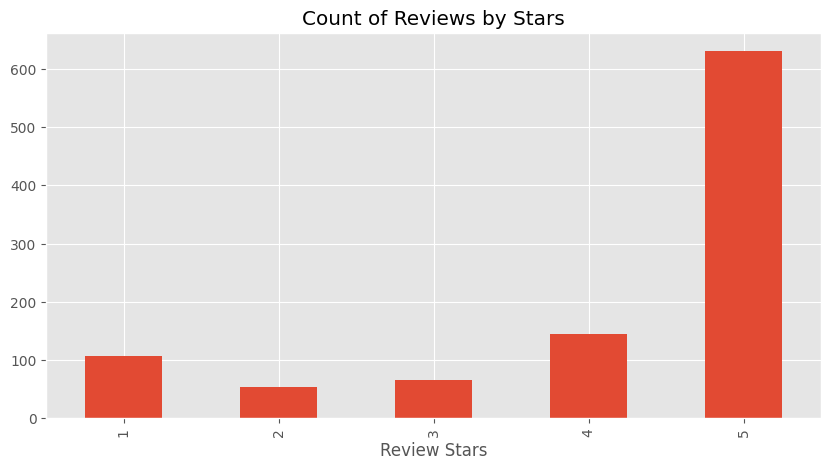

In [29]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

# VADER Sentiment Scoring

Using NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- will use a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [20]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [31]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [32]:
sia = SentimentIntensityAnalyzer()

# Runnig the polarity score on entire dataset

In [33]:
# as there were some float values in column so changed it to str
df['Text'] = df['Text'].astype(str)

In [34]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/1000 [00:00<?, ?it/s]

# Merging the sentiment score and metadata

In [35]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [36]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,299504,0.057,0.836,0.107,0.6287,B00142BX68,A1DI7KMBSK5MTU,Victoria Satterfield,11,12,5,1250726400,Anecdotal evidence was too true for me!,I drank 3 cups brewed with 2 tea bags each of ...
1,390840,0.000,0.531,0.469,0.8329,B000P54HVS,A377RH60YJ8OCZ,P. Jain,0,0,4,1182902400,Good breakfast,Toast it for 1 min. perfect breakfast. I wish ...
2,243867,0.036,0.822,0.142,0.9022,B000EQT4MA,A2J4IRVIMRWPSZ,A. Crank,0,0,4,1243555200,"chips were stale, but my money was refunded",I purchased these chips since they are so much...
3,410666,0.000,0.749,0.251,0.9370,B000YCNFCY,A6PUI7LK6OZSU,mumser,0,0,5,1328659200,great - from a long time ago,Claxton fruitcake is just the best. We used t...
4,24922,0.013,0.820,0.166,0.9155,B0078Y6OX8,A1BB03CRRHU0RJ,"Jay Bird ""An Independent Thinker""",0,0,5,1291161600,Love it!,This is now my new favorite K-cup flavor! Any...


## Ploting VADER results

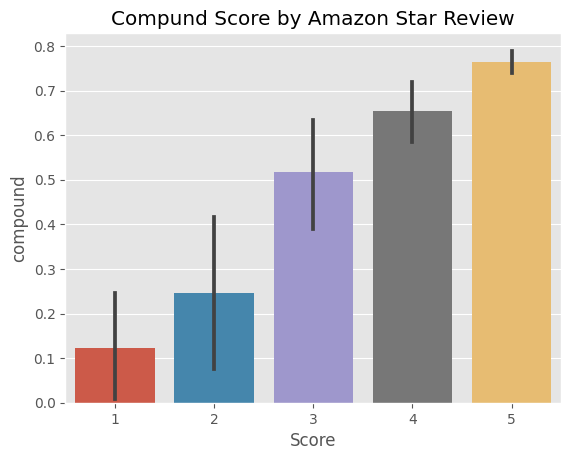

In [37]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

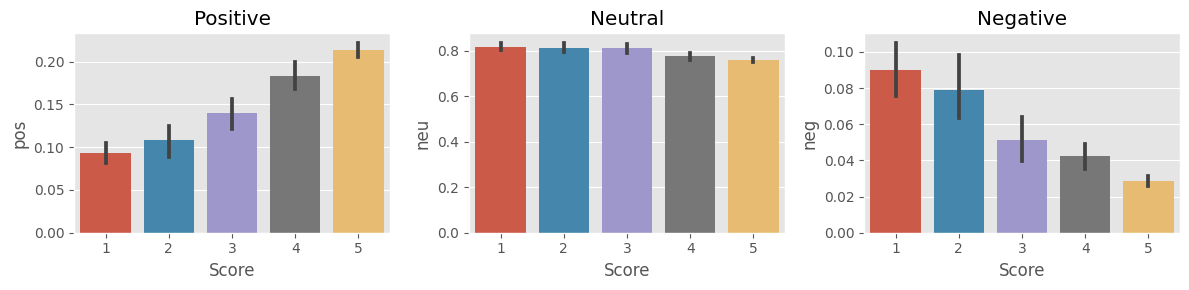

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Roberta Pretrained Model

- Using a model trained of a large corpus of data.

In [39]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.3 MB/s eta 0:00:00


In [40]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [41]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [42]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [43]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id 23110
Broke for id 455580
Broke for id 345845
Broke for id 220921
Broke for id 9910
Broke for id 149954
Broke for id 237786
Broke for id 514691
Broke for id 488548
Broke for id 104279


In [44]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

# Combine and compare

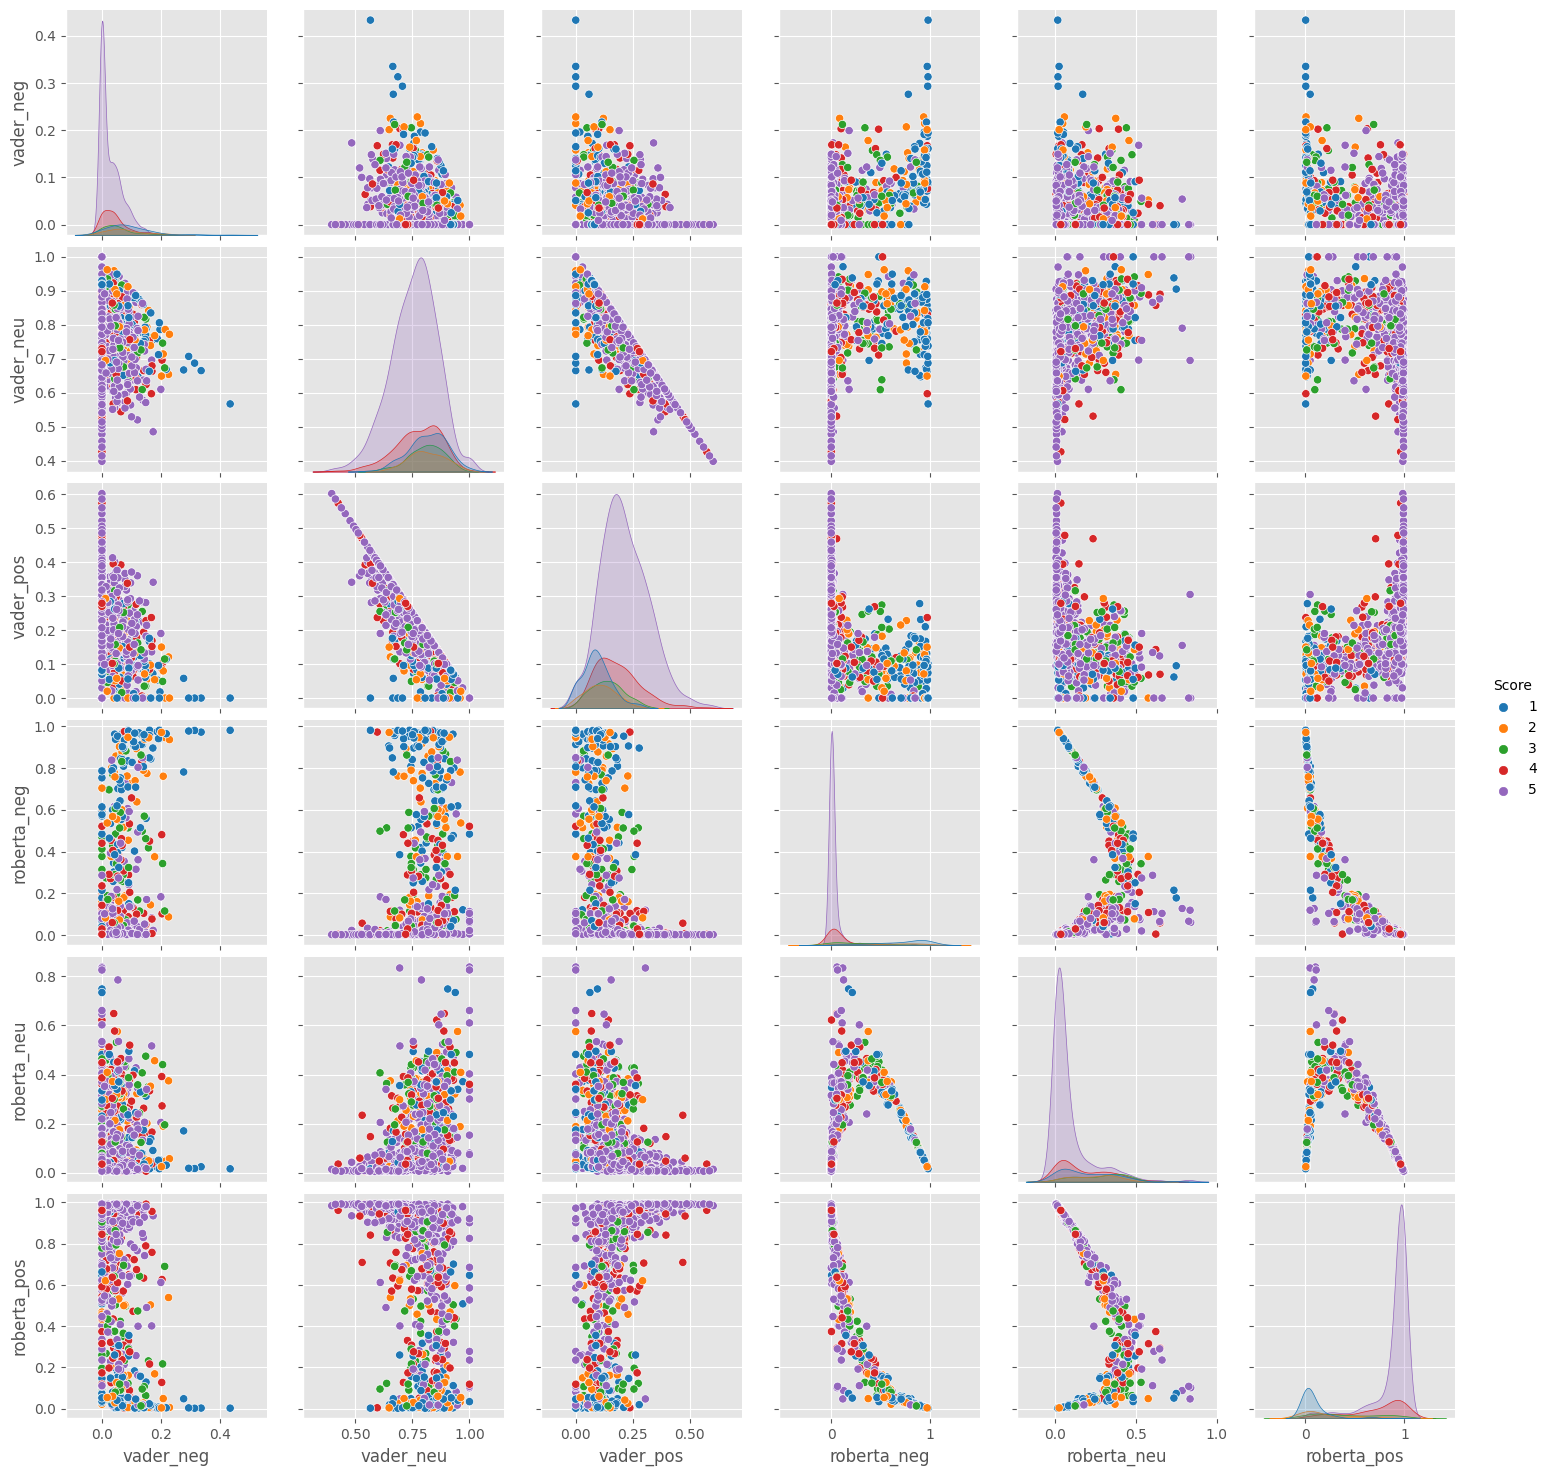

In [46]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [47]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'This is great candy, smooth and flavorful with a great \'mouth" as the TV chefs like to say.<br /><br />However-- six bucks for ten pieces of hard candy?  The dollar store stocks this pretty regularly. Same brand, same size-- one dollar.'

In [48]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'This is great candy, smooth and flavorful with a great \'mouth" as the TV chefs like to say.<br /><br />However-- six bucks for ten pieces of hard candy?  The dollar store stocks this pretty regularly. Same brand, same size-- one dollar.'

In [52]:
# negative sentiment 5-Star view

In [50]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

"Five stars isn't enough. There is nothing like Vernor's. Period. Canada Dry? Puh-leez...watered-down garbage. Vernor's is to Ginger Ale what Courvoisier is to Cognac. There IS no comparison. If you grew up in Michigan, you asked for Ginger Ale and you got Vernor's. Anything else is heresy.<br /><br />I can understand the review below, though. The poor fool's from Ohio. He obviously doesn't know any better."

In [51]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

"These are incredible!  Eating these makes me not want to eat candy.  I love these!  The price isn't that great though.  I think Blue Diamond should save money by packaging them in something cheaper than plastic.  I did notice it on Amazon in a box, but the price looks odd - over $50?  Too bad Amazon doesn't stock this, so no Free Shipping."

# The End